<a href="https://colab.research.google.com/github/benzaitsue/game/blob/main/Big_Data_Analysis_on_Disney%2B_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install pyspark

In [54]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install findspark

In [55]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Diesny plys Analysis") \
    .getOrCreate()


In [28]:
from google.colab import files

uploaded = files.upload()  #


Saving disney_plus_titles.csv to disney_plus_titles.csv


In [56]:
import pandas as pd
from io import StringIO

data_pd = pd.read_csv(StringIO(uploaded[next(iter(uploaded))].decode('utf-8')))

data = spark.createDataFrame(data_pd)

In [57]:
data = data.dropDuplicates()

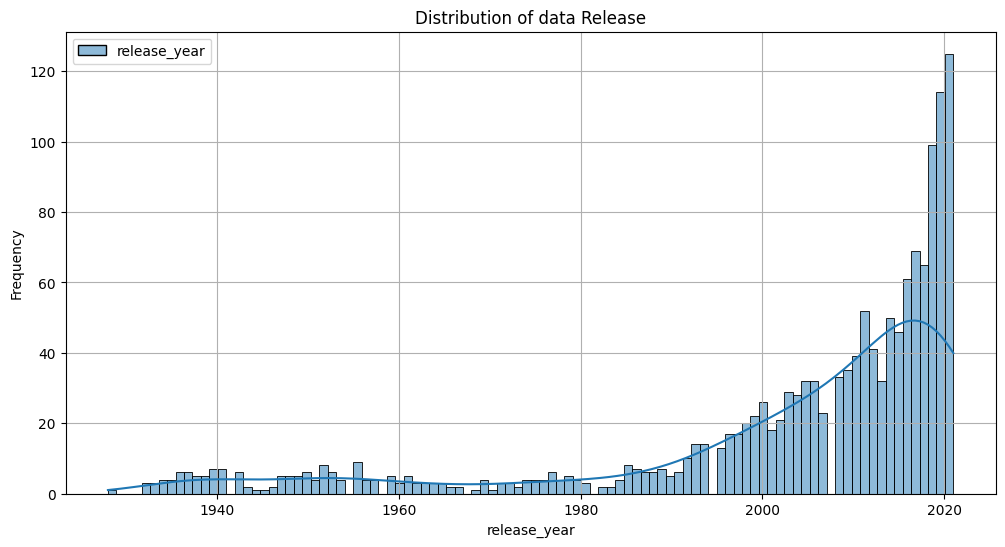

In [58]:
plt.figure(figsize=(12, 6))
sns.histplot(data.select("release_year").toPandas(), bins=100, kde=True, color='blue')
plt.title("Distribution of data Release")
plt.xlabel("release_year")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

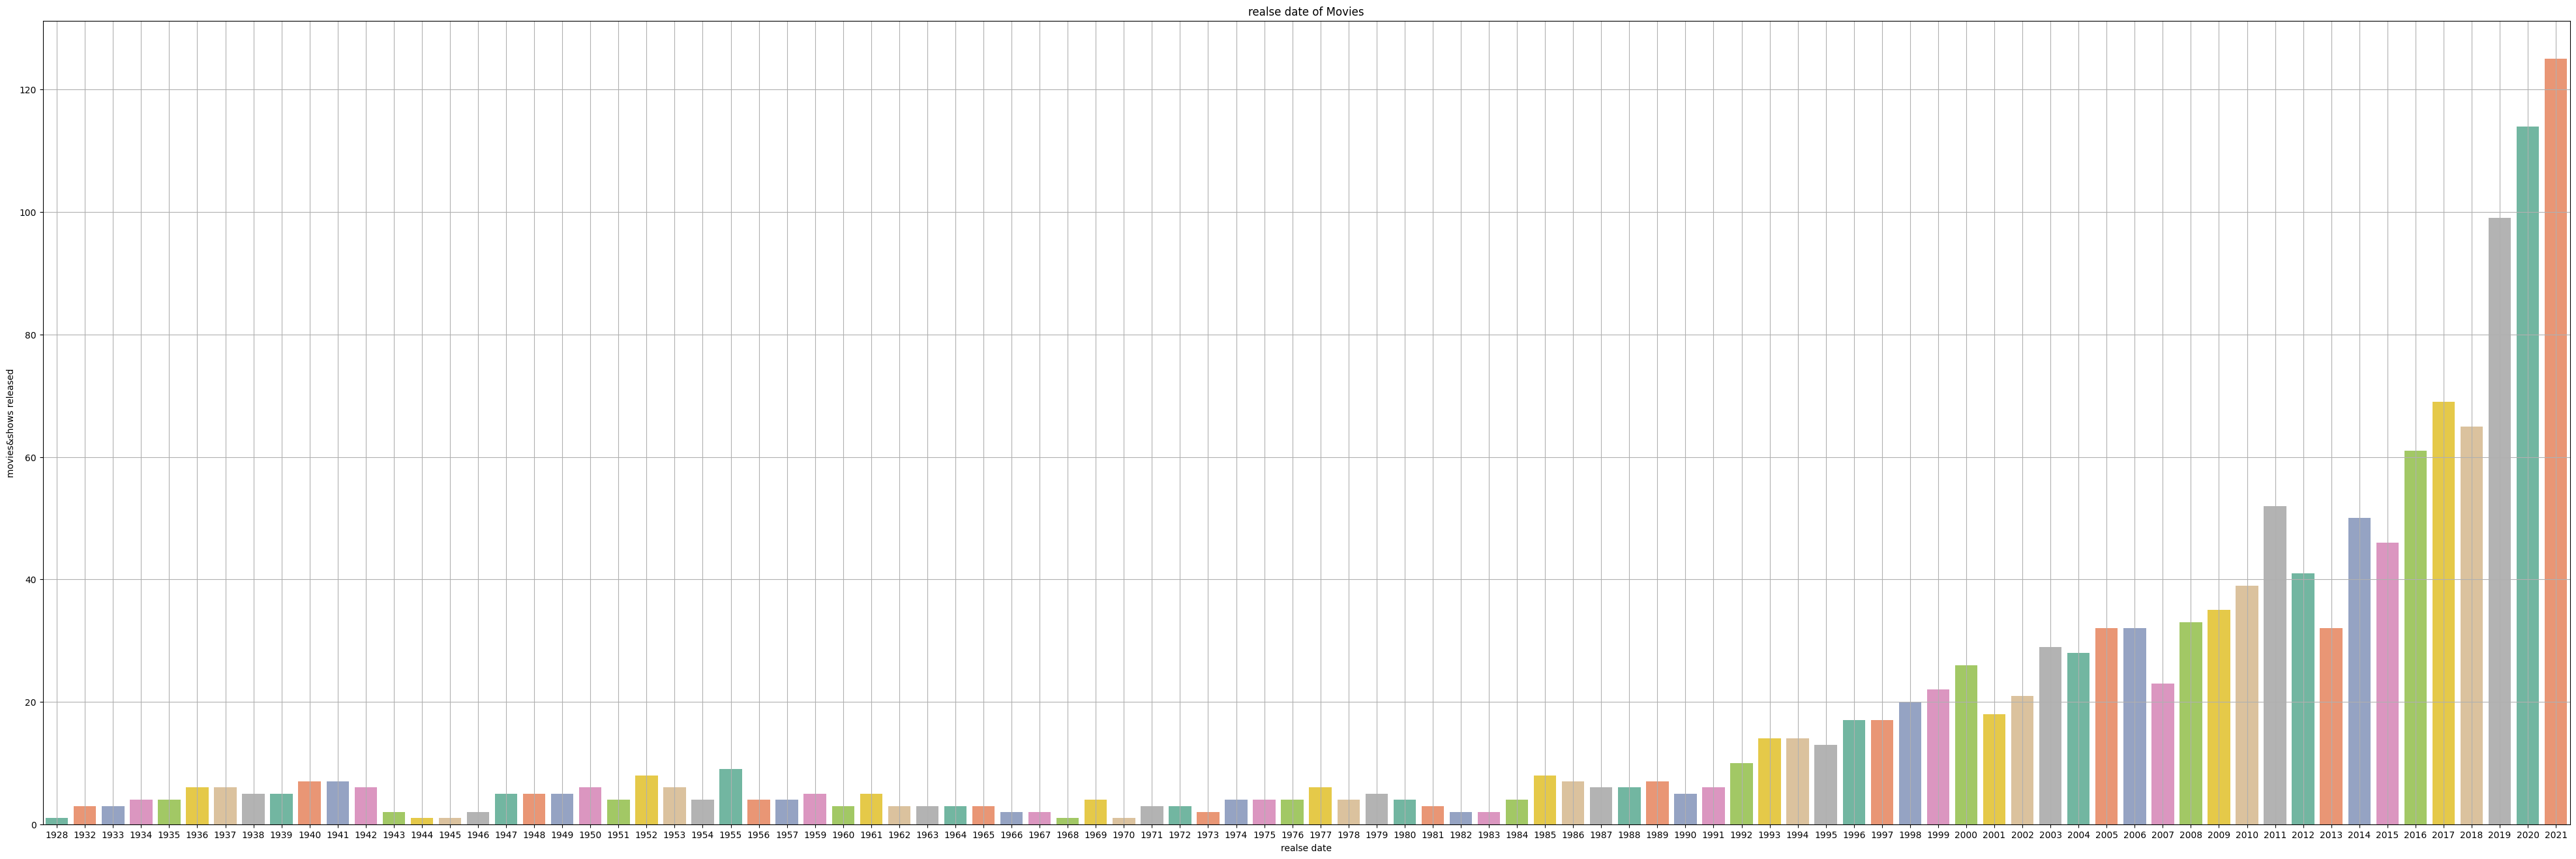

In [59]:
plt.figure(figsize=(50, 16))
sns.countplot(x='release_year', data=data.toPandas(), hue='release_year', palette='Set2', legend=False)
plt.title("realse date of Movies")
plt.ylabel("movies&shows released")
plt.xlabel("realse date")
plt.grid(True)
plt.show()

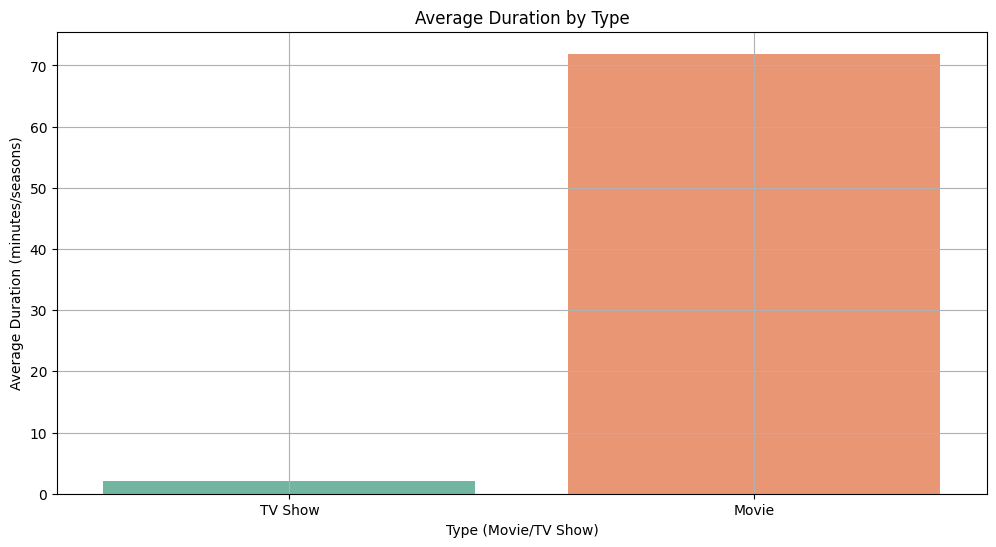

In [60]:
data = data.withColumn("duration_numeric", F.regexp_extract("duration", r"(\d+)", 1).cast("int"))
avg_duration = data.groupBy("type").agg(F.avg("duration_numeric").alias("Average_Duration")).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='Average_Duration', data=avg_duration, palette='Set2')
plt.title("Average Duration by Type")
plt.xlabel("Type (Movie/TV Show)")
plt.ylabel("Average Duration (minutes/seasons)")
plt.grid(True)
plt.show()

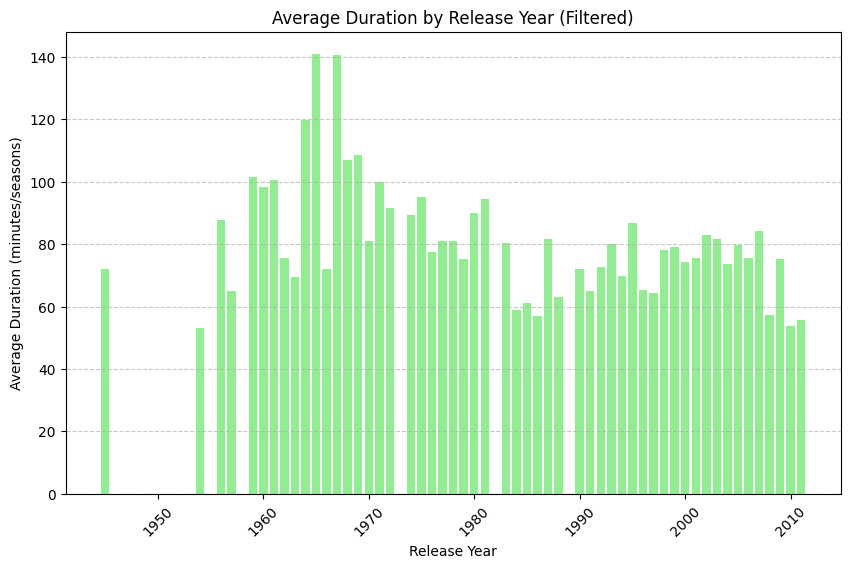

In [61]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

avg_duration_year = data.groupBy("release_year").agg(F.avg("duration_numeric").alias("avg_duration"))

filtered_avg_duration_year = avg_duration_year.filter(avg_duration_year.avg_duration > 50)

filtered_avg_duration_pd = filtered_avg_duration_year.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(filtered_avg_duration_pd['release_year'], filtered_avg_duration_pd['avg_duration'], color='lightgreen')
plt.title('Average Duration by Release Year (Filtered)')
plt.xlabel('Release Year')
plt.ylabel('Average Duration (minutes/seasons)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [62]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Group by 'listed_in' (categories/genres) and calculate the average duration
avg_genre_performance = data.groupBy("listed_in").agg(F.avg("duration_numeric").alias("avg_duration"))

# Convert to Pandas for visualization
avg_genre_performance_pd = avg_genre_performance.toPandas()

# Sort by average duration for better visualization
avg_genre_performance_pd = avg_genre_performance_pd.sort_values(by='avg_duration', ascending=False)

# Plotting the data
plt.figure(figsize=(270, 48))
plt.barh(avg_genre_performance_pd['listed_in'], avg_genre_performance_pd['avg_duration'], color='royalblue')
plt.title('Average Duration by Genre/Category')
plt.xlabel('Average Duration (minutes/seasons)')
plt.ylabel('Genre/Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


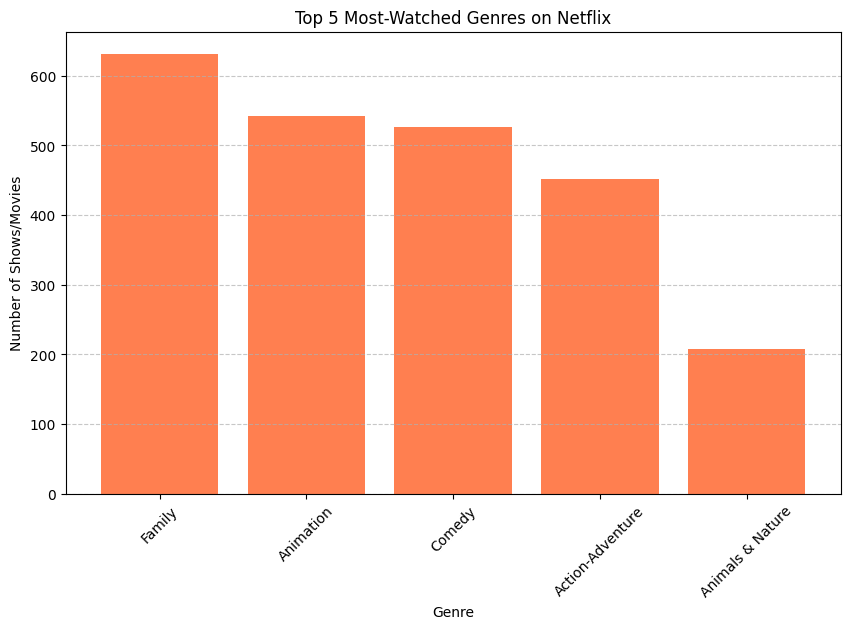

In [63]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Explode 'listed_in' to count each genre separately if it contains multiple genres per row
data = data.withColumn("genre", F.explode(F.split(F.col("listed_in"), ", ")))

# Count the number of entries for each genre
genre_counts = data.groupBy("genre").count().orderBy(F.desc("count"))

# Get the top 5 most-watched genres
top_5_genres = genre_counts.limit(5).toPandas()

# Plotting the top 5 genres
plt.figure(figsize=(10, 6))
plt.bar(top_5_genres['genre'], top_5_genres['count'], color='coral')
plt.title('Top 5 Most-Watched Genres on Netflix')
plt.xlabel('Genre')
plt.ylabel('Number of Shows/Movies')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [64]:
from pyspark.sql.functions import when, col

# Create a new column 'View_Trend' based on duration
data = data.withColumn(
    "View_Trend",
    when(col("duration_numeric") >= 100, 1).otherwise(0)  # Example: Mark as 1 if duration >= 100 minutes/seasons
)

# Show sample data
data.select("title", "duration", "duration_numeric", "View_Trend").show(10)


+--------------------+--------+----------------+----------+
|               title|duration|duration_numeric|View_Trend|
+--------------------+--------+----------------+----------+
|       A Spark Story|  88 min|              88|         0|
|Fantastic Four: R...|  93 min|              93|         0|
|Fantastic Four: R...|  93 min|              93|         0|
|Fantastic Four: R...|  93 min|              93|         0|
|Squanto: A Warrio...| 102 min|             102|         1|
|Squanto: A Warrio...| 102 min|             102|         1|
|Squanto: A Warrio...| 102 min|             102|         1|
|George of the Jungle|  93 min|              93|         0|
|George of the Jungle|  93 min|              93|         0|
|George of the Jungle|  93 min|              93|         0|
+--------------------+--------+----------------+----------+
only showing top 10 rows



In [65]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Index categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(data)
            for column in ["type", "listed_in", "country"]]  # Use relevant columns like type, listed_in, etc.

# Assemble features into a single vector
feature_columns = ["type_index", "listed_in_index", "country_index",
                   "release_year", "duration_numeric"]  # Include numeric columns like release_year, duration_numeric

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# Apply the pipeline
data_transformed = pipeline.fit(data).transform(data)

# Show transformed data
data_transformed.select("features", "type_index", "listed_in_index").show(5, truncate=False)


+----------------------------+----------+---------------+
|features                    |type_index|listed_in_index|
+----------------------------+----------+---------------+
|[0.0,30.0,1.0,2021.0,88.0]  |0.0       |30.0           |
|[0.0,13.0,19.0,2007.0,93.0] |0.0       |13.0           |
|[0.0,13.0,19.0,2007.0,93.0] |0.0       |13.0           |
|[0.0,13.0,19.0,2007.0,93.0] |0.0       |13.0           |
|[0.0,161.0,2.0,1994.0,102.0]|0.0       |161.0          |
+----------------------------+----------+---------------+
only showing top 5 rows



In [66]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Initialize the Logistic Regression classifier with the correct label column
lr = LogisticRegression(labelCol="View_Trend", featuresCol="features")

# Create a pipeline with indexers, assembler, and logistic regression
pipeline = Pipeline(stages=indexers + [assembler, lr])

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator (AUC)
evaluator = BinaryClassificationEvaluator(labelCol="View_Trend", rawPredictionCol="probability", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.2f}")

# Optional: Display sample predictions
predictions.select("features", "View_Trend", "prediction", "probability").show(10, truncate=False)


AUC: 1.00
+----------------------------+----------+----------+---------------------------+
|features                    |View_Trend|prediction|probability                |
+----------------------------+----------+----------+---------------------------+
|[0.0,129.0,0.0,2008.0,45.0] |0         |0.0       |[1.0,0.0]                  |
|[0.0,248.0,0.0,2009.0,106.0]|1         |1.0       |[4.304001415761347E-81,1.0]|
|[0.0,67.0,0.0,2015.0,9.0]   |0         |0.0       |[1.0,0.0]                  |
|[1.0,1.0,0.0,2016.0,1.0]    |0         |0.0       |[1.0,0.0]                  |
|[1.0,1.0,1.0,2018.0,1.0]    |0         |0.0       |[1.0,0.0]                  |
|[1.0,1.0,54.0,2015.0,1.0]   |0         |0.0       |[1.0,0.0]                  |
|[1.0,1.0,1.0,2016.0,1.0]    |0         |0.0       |[1.0,0.0]                  |
|[0.0,1.0,29.0,2014.0,24.0]  |0         |0.0       |[1.0,0.0]                  |
|[0.0,1.0,0.0,2014.0,24.0]   |0         |0.0       |[1.0,0.0]                  |
|[0.0,1.0,0.0,2014

In [67]:
from pyspark.sql.functions import col

# Compare predictions with actual labels to calculate accuracy
correct_predictions = predictions.filter(col("View_Trend") == col("prediction")).count()
total_predictions = predictions.count()

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


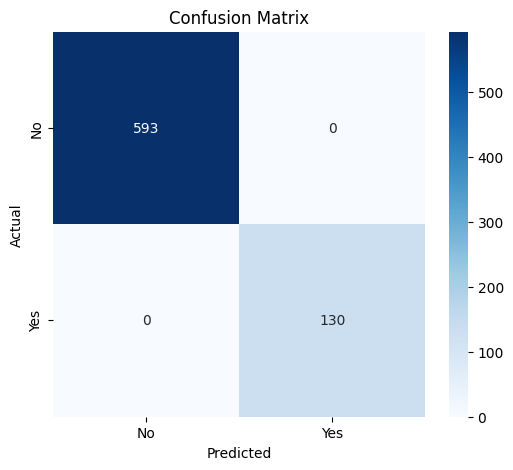

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame for confusion matrix calculation
actual_predicted_df = predictions.select("View_Trend", "prediction").toPandas()

# Extract actual and predicted values as numpy arrays
actual = actual_predicted_df['View_Trend'].values
predicted = actual_predicted_df['prediction'].values

# Generate confusion matrix
cm = confusion_matrix(actual, predicted)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
